# Homework

1. Train NN model with custom linear architecture on MNIST or on any dataset from Kaggle (image data with resolution not higher than 80x80 pixels - 
[Sign language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist), 
[A-Z Handwritten Alphabet](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format), etc.)
2. Visualize epoch progress (loss and accuracy curves)
3. Visualize 10 random elements from test set and model results for those elements

In [61]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import random
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading data

In [62]:
file_path = 'E:/Camp all task/Task_27.(pytorch)/MNIST/sign_mnist_train.csv'
df_train = pd.read_csv(file_path)

df_train[:10]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [63]:
file_path = 'E:/Camp all task/Task_27.(pytorch)/MNIST/sign_mnist_test.csv'
df_test = pd.read_csv(file_path)

df_test[:10]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
5,21,72,79,87,101,115,124,131,135,139,...,187,189,192,193,194,194,194,195,195,194
6,10,93,100,112,118,123,127,131,133,136,...,173,175,177,178,180,180,181,181,181,183
7,14,177,177,177,177,177,178,179,179,178,...,232,223,224,224,223,221,221,221,220,219
8,3,191,194,196,198,201,203,204,205,205,...,43,57,78,64,47,62,65,62,62,68
9,7,171,172,172,173,173,173,173,173,172,...,199,199,198,196,195,194,183,85,65,124


## Definition of the MyDataset class

In [64]:
class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        image = np.array(self.dataframe.iloc[idx, 1:]).astype(
            np.uint8).reshape((28, 28, 1))
        image = Image.fromarray(image.squeeze())

        if self.transform:
            image = self.transform(image)

        return image, label

## Data processing

In [65]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Train_dataset = MyDataset(df_train, transform=transform)
Test_dataset = MyDataset(df_test, transform=transform)

## Split training data into training and testing sets

In [66]:
train_size = int(0.8 * len(Train_dataset))
test_size = len(Train_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    Train_dataset, [train_size, test_size])

## Create DataLoader

In [67]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Test_dataset = DataLoader(Test_dataset, batch_size=64, shuffle=True)

## Creating model

In [68]:
label_mapping = dict(zip(df_train, list(range(len(df_train)))))

In [69]:
class My_NN_Model(nn.Module):
    def __init__(self, input_size, output_size):
        output_size = 26
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

output_size = len(label_mapping)
input_size = torch.numel(Train_dataset[0][0])

model = My_NN_Model(input_size, output_size).to(device)
model

My_NN_Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=26, bias=True)
  )
)

In [70]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

In [71]:
def train_loop(dataloader, model, criterion, optimizer, epoch):
    model.train()
    total_loss = 0.0

    tqdm_loader = tqdm(dataloader, unit="batch",
                       desc=f"Epoch {epoch}", total=len(dataloader))
    for batch, (X, y) in enumerate(tqdm_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if batch % 1000 == 0:
            tqdm_loader.set_postfix(loss=loss.item())

    average_loss = total_loss / len(dataloader)
    return average_loss


def test_loop(dataloader, model, criterion):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct

    print(
        f"Test Error: \n Accuracy: {accuracy:.1f}%, Avg loss: {test_loss:.8f} \n")

    return test_loss, accuracy

In [72]:
epochs = 10
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, epochs + 1):
    train_loss = train_loop(train_loader, model, criterion, optimizer, epoch)
    test_loss, accuracy_val = test_loop(test_loader, model, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy_val)  # Store accuracy values

Epoch 1: 100%|██████████| 344/344 [00:10<00:00, 33.66batch/s, loss=3.25]


Test Error: 
 Accuracy: 97.0%, Avg loss: 0.11355459 



Epoch 2: 100%|██████████| 344/344 [00:10<00:00, 31.80batch/s, loss=0.0424]


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.02520718 



Epoch 3: 100%|██████████| 344/344 [00:11<00:00, 30.04batch/s, loss=0.0198]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00142148 



Epoch 4: 100%|██████████| 344/344 [00:10<00:00, 34.27batch/s, loss=0.00144]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00086698 



Epoch 5: 100%|██████████| 344/344 [00:10<00:00, 32.90batch/s, loss=0.00122]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00060319 



Epoch 6: 100%|██████████| 344/344 [00:10<00:00, 34.30batch/s, loss=0.000296]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00043087 



Epoch 7: 100%|██████████| 344/344 [00:09<00:00, 34.71batch/s, loss=0.000103]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00031649 



Epoch 8: 100%|██████████| 344/344 [00:09<00:00, 34.57batch/s, loss=0.000175]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00025200 



Epoch 9: 100%|██████████| 344/344 [00:11<00:00, 29.42batch/s, loss=0.000188]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00019228 



Epoch 10: 100%|██████████| 344/344 [00:12<00:00, 28.04batch/s, loss=0.000106]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.00015013 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


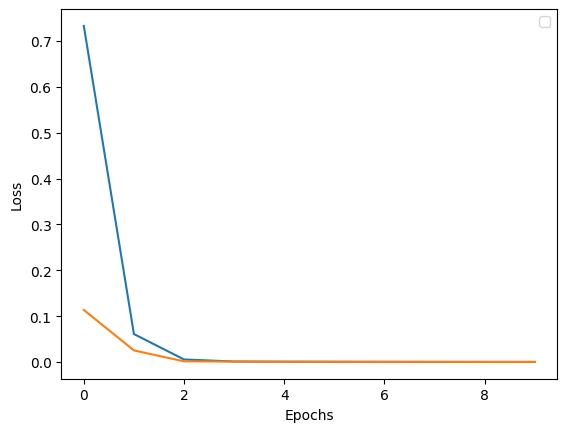

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


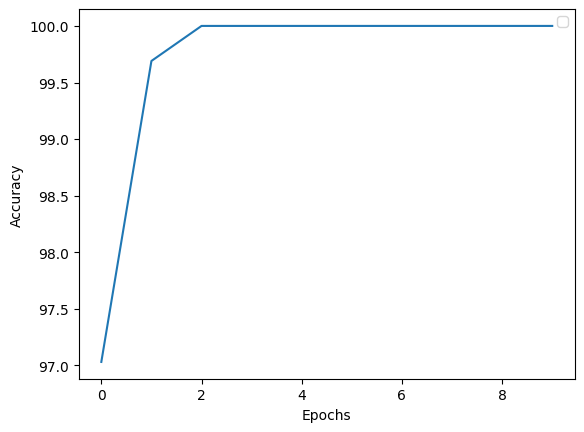

In [73]:
# Plot the progress after each epoch
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

torch.save(model, 'model.pth')
# OR
torch.save(model.state_dict(), 'model_state.pth')

## Visualize 10 random elements from the test set and model results

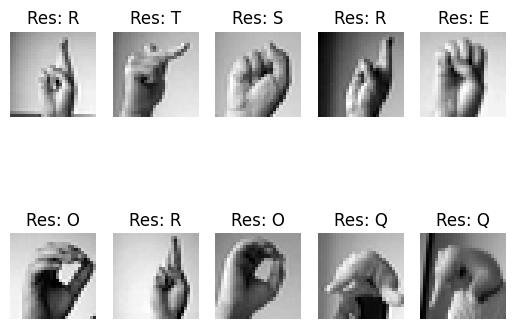

In [74]:
model.eval()
with torch.no_grad():
    for i in range(10):
        idx = random.randint(0, len(test_dataset) - 1)
        input_image, true_label = test_dataset[idx]
        input_image = input_image.unsqueeze(0)
        output = model(input_image)
        _, predicted_label = torch.max(output, 1)

        # Mapping between numeric labels and English letters
        label_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
                         10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
                         20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


        plt.subplot(2, 5, i+1)
        plt.imshow(input_image.squeeze().numpy(), cmap='gray')
        plt.title(
            f'Res: {label_mapping[predicted_label.item()]}')
        plt.axis('off')

plt.show()